In [ ]:
# default_exp gcp_helpers

# EUMETSAT and GCP 

The intention is to run a DAG using Google Cloud Composer that:  

1. Uses the EUMETSAT DownloadManager will check for available files over a time period.  
2. Compares with already downloaded files in a GCP bucket
3. Downloads any files not already downloaded, compressed using `pbzip2`

Run on europe-west4 (Netherlands) by preference.  

Our bucket and an example folder prefix is defined below.  

The data is stored in the format `gs://solar-pv-nowcasting-data/satellite/EUMETSAT/SEVIRI_RSS/native/<year>/<month>/<day>/<hour>/<minute>/` as per the existing files.

### Setup

In [3]:
#export
from google.cloud import storage
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import dotenv
import pandas_gbq

## Some GCP Helpers

First need a couple of helper functions to work with Google Cloud Platform.  
Ideally the principles will transfer easily to other cloud providers if necessary. 

In [4]:
#export 
def list_blobs_with_prefix(bucket_name, prefix, delimiter=None):
    """Lists all the blobs in the bucket that begin with the prefix.

    This can be used to list all blobs in a "folder", e.g. "public/".

    The delimiter argument can be used to restrict the results to only the
    "files" in the given "folder". Without the delimiter, the entire tree under
    the prefix is returned. For example, given these blobs:

        a/1.txt
        a/b/2.txt

    If you just specify prefix = 'a', you'll get back:

        a/1.txt
        a/b/2.txt

    However, if you specify prefix='a' and delimiter='/', you'll get back:

        a/1.txt

    Additionally, the same request will return blobs.prefixes populated with:

        a/b/
    """

    storage_client = storage.Client()

    # Note: Client.list_blobs requires at least package version 1.17.0.
    blobs = storage_client.list_blobs(bucket_name, prefix=prefix, delimiter=delimiter)

    names = []

    for blob in blobs:
        names.append(blob.name)
    return names


def blob_metadata(bucket_name, blob_name):
    """Prints out a blob's metadata."""
    # bucket_name = 'your-bucket-name'
    # blob_name = 'your-object-name'

    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.get_blob(blob_name)

    print("Blob: {}".format(blob.name))
    print("Bucket: {}".format(blob.bucket.name))
    print("Storage class: {}".format(blob.storage_class))
    print("ID: {}".format(blob.id))
    print("Size: {} bytes".format(blob.size))
    print("Updated: {}".format(blob.updated))
    print("Generation: {}".format(blob.generation))
    print("Metageneration: {}".format(blob.metageneration))
    print("Etag: {}".format(blob.etag))
    print("Owner: {}".format(blob.owner))
    print("Component count: {}".format(blob.component_count))
    print("Crc32c: {}".format(blob.crc32c))
    print("md5_hash: {}".format(blob.md5_hash))
    print("Cache-control: {}".format(blob.cache_control))
    print("Content-type: {}".format(blob.content_type))
    print("Content-disposition: {}".format(blob.content_disposition))
    print("Content-encoding: {}".format(blob.content_encoding))
    print("Content-language: {}".format(blob.content_language))
    print("Metadata: {}".format(blob.metadata))

In [5]:
#export
def upload_blob(bucket_name, source_file_name, destination_blob_name, prefix=None, log=None):
    """Uploads a file to the bucket."""
    # bucket_name = "your-bucket-name"
    # source_file_name = "local/path/to/file"
    # destination_blob_name = "storage-object-name"

    if prefix:
        destination_blob_name = prefix + destination_blob_name
    
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    # For slow upload speed
    storage.blob._DEFAULT_CHUNKSIZE = 2097152 # 1024 * 1024 B * 2 = 2 MB
    storage.blob._MAX_MULTIPART_SIZE = 2097152 # 2 MB
    
    blob.upload_from_filename(source_file_name)

    print(
        "File {} uploaded to {}.".format(
            source_file_name, destination_blob_name
        )
    )
    if log:
        log.info("File {} uploaded to {}.".format(
                source_file_name, destination_blob_name
            )
        )

## User input

Finding out how much data has been downloaded for different years in the OCF native data bucket.

In [9]:
BUCKET_NAME = "solar-pv-nowcasting-data"
PREFIX = "satellite/EUMETSAT/SEVIRI_RSS/native/2019/01/01"

In [10]:
blobs = list_blobs_with_prefix(BUCKET_NAME, prefix=PREFIX)

In [11]:
print(f'There are {len(blobs)} files')

There are 277 files


In [12]:
blobs[:10]

['satellite/EUMETSAT/SEVIRI_RSS/native/2019/01/01/00/04/MSG3-SEVI-MSG15-0100-NA-20190101000417.314000000Z-20190101000435-1377854-1.nat.bz2',
 'satellite/EUMETSAT/SEVIRI_RSS/native/2019/01/01/00/09/MSG3-SEVI-MSG15-0100-NA-20190101000917.390000000Z-20190101000935-1377854-1.nat.bz2',
 'satellite/EUMETSAT/SEVIRI_RSS/native/2019/01/01/00/14/MSG3-SEVI-MSG15-0100-NA-20190101001417.466000000Z-20190101001435-1377854-1.nat.bz2',
 'satellite/EUMETSAT/SEVIRI_RSS/native/2019/01/01/00/19/MSG3-SEVI-MSG15-0100-NA-20190101001917.542000000Z-20190101001935-1377854-1.nat.bz2',
 'satellite/EUMETSAT/SEVIRI_RSS/native/2019/01/01/00/24/MSG3-SEVI-MSG15-0100-NA-20190101002417.618000000Z-20190101002436-1377854-1.nat.bz2',
 'satellite/EUMETSAT/SEVIRI_RSS/native/2019/01/01/00/29/MSG3-SEVI-MSG15-0100-NA-20190101002917.694000000Z-20190101002935-1377854-1.nat.bz2',
 'satellite/EUMETSAT/SEVIRI_RSS/native/2019/01/01/00/34/MSG3-SEVI-MSG15-0100-NA-20190101003417.770000000Z-20190101003435-1377854-1.nat.bz2',
 'satellite/E

Lets see how large the data for the whole of 2018 is - this may take a few minutes to run. 

In [13]:
storage_client = storage.Client()
PREFIX = "satellite/EUMETSAT/SEVIRI_RSS/native/2018/"

# Note: Client.list_blobs requires at least package version 1.17.0.
blobs_ = storage_client.list_blobs(BUCKET_NAME, prefix=PREFIX)

sizes = []

for blob in blobs_:
    sizes.append(blob.size)

In [14]:
sum(sizes) / 1e9

2443.493799523

2018 contains 2.4TB of data

Note that using the storage client to return blobs returns an iterable of blob metadata objects.  
From those we've extracted the names. We can go backwards from the names to interact with the blobs. 

In [15]:
df = pd.DataFrame(blobs, columns=['blobs'])
df = df[df['blobs'].str.endswith('.nat.bz2')] # only compressed data files
df['datetime'] = pd.to_datetime(df['blobs'].str.slice(start=37, stop=53), format="%Y/%m/%d/%H/%M")

In [16]:
months_in_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

In [17]:
blobs_by_month = df\
        .assign(year=lambda x: x['datetime'].dt.year)\
        .assign(month=lambda x: x['datetime'].dt.month_name())\
        .groupby(['month', 'year']).count()['blobs'].to_frame()\
        .reset_index()\
        .pivot(index='month', columns='year', values='blobs')\
        .reindex(months_in_order)

blobs_by_month

year,2019
month,
January,276.0
February,NaN
March,NaN
April,NaN
May,NaN
June,NaN
July,NaN
August,NaN
September,NaN


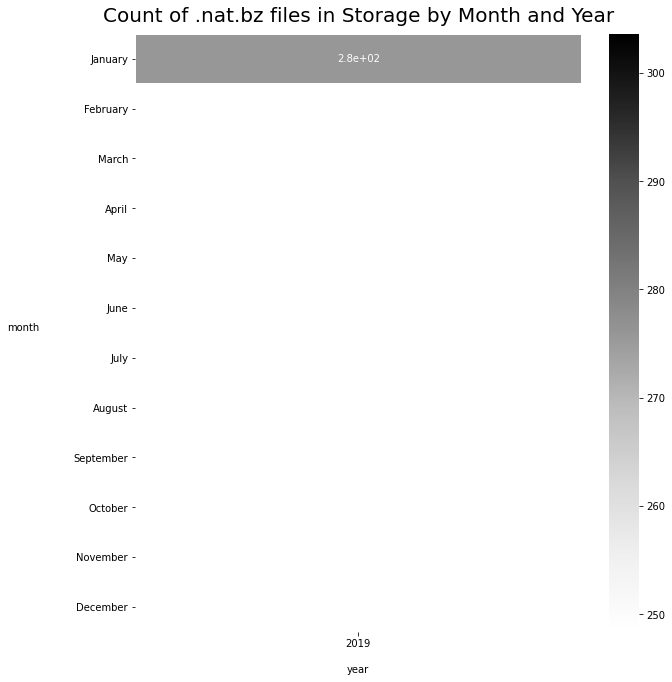

In [18]:
# credit: https://dfrieds.com/data-visualizations/visualize-historical-time-comparisons.html

figure, axes = plt.subplots(figsize=(10, 11))
sns.heatmap(blobs_by_month, annot=True, linewidths=.5, ax=axes, cmap="Greys")
axes.axes.set_title("Count of .nat.bz files in Storage by Month and Year", fontsize=20, y=1.01)
axes.axes.set_ylabel("month", labelpad=50, rotation=0)
axes.axes.set_xlabel("year", labelpad=16);
plt.yticks(rotation=0);

In [124]:
filenames = df['blobs'].str.split('/').str[-1].str.replace('.bz2', '')

In [125]:
filenames

1         MSG3-SEVI-MSG15-0100-NA-20180531000417.2340000...
2         MSG3-SEVI-MSG15-0100-NA-20180531000917.4680000...
3         MSG3-SEVI-MSG15-0100-NA-20180531001417.7010000...
4         MSG3-SEVI-MSG15-0100-NA-20180531001917.9350000...
5         MSG3-SEVI-MSG15-0100-NA-20180531002416.3640000...
                                ...                        
170664    MSG3-SEVI-MSG15-0100-NA-20191231233418.2450000...
170665    MSG3-SEVI-MSG15-0100-NA-20191231233916.9530000...
170666    MSG3-SEVI-MSG15-0100-NA-20191231234415.6620000...
170667    MSG3-SEVI-MSG15-0100-NA-20191231234914.3700000...
170668    MSG3-SEVI-MSG15-0100-NA-20191231235414.2810000...
Name: blobs, Length: 170667, dtype: object

In [11]:
#export
def get_eumetsat_filenames(bucket_name, prefix, delimiter=None):
    """Lists all the blobs in the bucket that begin with the prefix.

    This can be used to list all blobs in a "folder", e.g. "public/".

    The delimiter argument can be used to restrict the results to only the
    "files" in the given "folder". Without the delimiter, the entire tree under
    the prefix is returned. For example, given these blobs:

    """

    storage_client = storage.Client()

    # Note: Client.list_blobs requires at least package version 1.17.0.
    blobs = storage_client.list_blobs(bucket_name, prefix=prefix, delimiter=delimiter)

    names = []

    for blob in blobs:
        if blob.name.endswith('.nat.bz2'):
            filename = blob.name.split('/')[-1].replace('.bz2', '')
            names.append(filename)
    return names

In [12]:
PREFIX = "satellite/EUMETSAT/SEVIRI_RSS/native/2019/10/01"
filenames = get_eumetsat_filenames(BUCKET_NAME, prefix=PREFIX)

In [130]:
len(filenames)

68202

## Write metadata to bigquery

For cloud storage functions, storing metadata in a RDBS seems useful. BigQuery is a low hassle way to achieve this and can scale to lots of data with ease.  
Downsides are rather inflexible migrations and updates.  


In [30]:
# export
def write_metadata_to_gcp(df, table_id, project_id, credentials=None, append=True):
    if append:
        if_exists = "append"
    else:
        if_exists = "fail"
        
    if credentials:
        pandas_gbq.to_gbq(
            df,
            table_id,
            project_id=project_id,
            credentials=credentials,
            if_exists=if_exists,
        )
    else:
        pandas_gbq.to_gbq(
            df,
            table_id,
            project_id=project_id,
            if_exists=if_exists,
        )
        
    print(
        f"{len(df)} rows written to BQ {table_id}, append={append}"
    )

In [29]:
# write_metadata_to_gcp(df, 'test', 'solar-pv-nowcasting')

NotFoundException: Invalid Table Name. Should be of the form 'datasetId.tableId' 

In [8]:
#export
def query(sql_query, project_id):
    """Wrapper around BigQuery for a given Google project
        
        Returns:
            pandas.DataFrame of the query results
    """
    df = pandas_gbq.read_gbq(sql_query, project_id=project_id)
    
    return df

sql_query = 'select * from eumetsat.metadata where result_time = (select max(result_time) from eumetsat.metadata)'
project_id = 'solar-pv-nowcasting'

query(sql_query, project_id)['result_time'].iloc[0].strftime('%Y-%m-%d %H:%M')

Downloading: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30rows/s]


'2020-12-03 19:14'

In [9]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_utils.ipynb.
Converted 01_eumetsat.ipynb.
Converted 02_reproj.ipynb.
Converted 03_zarr.ipynb.
Converted 04_gcp.ipynb.
Converted 05_pipeline.ipynb.
